In [1]:
import torch
import math
import numpy as np
import xalglib
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Problem

## sklearn: LogisticRegression

In [2]:
X, y = load_breast_cancer(True)
X = (X - X.mean(axis=0)) / X.std(axis=0) + np.random.randn(*X.shape)
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

In [3]:
log_reg = LogisticRegression(penalty='none', fit_intercept=False, solver='newton-cg', tol=1e-7)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=1e-07, verbose=0,
                   warm_start=False)

In [4]:
x_opt = log_reg.coef_[0]

In [5]:
x_opt

array([-0.79958168, -0.54571695, -0.51906312, -0.11792283, -0.02262045,
       -0.55188501, -0.1911352 , -0.4243348 ,  0.15537339,  0.18411131,
       -1.15803487, -0.00876188, -0.65974608, -0.40164107, -0.04764733,
       -0.33422752,  0.32886424, -0.18277646,  0.30442109,  0.89567177,
       -0.60535583, -0.72130665, -1.2434206 , -0.36327027, -0.61822979,
       -0.34115297, -0.25764687, -0.43840302, -0.78910538, -0.22289441,
        1.35780598])

In [6]:
log_reg.score(X, y)

0.9595782073813708

In [7]:
log_loss(y, log_reg.predict_proba(X))

0.12020288385500831

## PyTorch: optimization problem

In [8]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

x_opt = torch.tensor(x_opt, dtype=torch.float32)
N = x_opt.shape[0]

x_0 = torch.randn(N)

In [9]:
def f(x):
    return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)

In [10]:
f(x_opt).item()

0.12020285427570343

In [11]:
f(x_0).item()

2.628032684326172

In [12]:
def check_optimality(f, x, step=1e-4, eps=1e-7):
    n = x.shape[0]
    fx = f(x)
    for i in range(n):
        for s in [-1, 1]:
            y = x.clone()
            y[i] += s * step
            fy = f(y)
            if fy < fx - eps:
                return False
    return True

In [13]:
check_optimality(f, x_0)

False

In [14]:
check_optimality(f, x_opt)

True

# Helper functions

In [62]:
def d_p(x, p):
    '''
    Prox-function
    '''
    return 1 / p * torch.norm(x)**p


def gradient(f, x, create_graph=False, retain_graph=None):
    '''
    Gradient of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    return torch.autograd.grad(
        outputs=[f],
        inputs=[x],
        create_graph=create_graph, 
        retain_graph=retain_graph)[0]


def hessian(f, x, create_graph=False):
    '''
    Hessian of scalar function 'f' w.r.t. 1-d vector 'x'
    '''
    n = x.shape[0]
    h = torch.empty(n, n)
    g = gradient(f, x, True)
    for i in range(n):
        h[i] = gradient(g[i], x, create_graph, True)
    return h


def D3(f, x, create_graph=False):
    n = x.shape[0]
    d3 = torch.empty(n, n, n)
    g = gradient(f, x, True)
    for i in range(n):
        d3[i] = hessian(g[i], x, create_graph)
    return d3


def hessian_vector_product(f, x, v, retain_graph=False):
    '''
    Hessian-vector product: D^2(f) @ v
    '''
    grad_f = gradient(f, x, True)
    return gradient(grad_f @ v, x, retain_graph=retain_graph)

In [37]:
def test():
    x = torch.tensor([1.5, 2.5], requires_grad=True)
    e = torch.tensor([1., 1.])
    f = x.pow(2).prod()
    print('F =', f, '\n')

    g = gradient(f, x, retain_graph=True)
    print('g =', g, '\n')

    h = hessian(f, x)
    print('h =', h, '\n')

    he = hessian_vector_product(f, x, e, retain_graph=True)
    print('h @ e =', he, '\n')
    
    d3 = D3(f, x)
    print('d3 =', d3, '\n')

test()

F = tensor(14.0625, grad_fn=<ProdBackward0>) 

g = tensor([18.7500, 11.2500]) 

h = tensor([[12.5000, 15.0000],
        [15.0000,  4.5000]]) 

h @ e = tensor([27.5000, 19.5000]) 

d3 = tensor([[[ 2.8610e-06,  1.0000e+01],
         [ 1.0000e+01,  6.0000e+00]],

        [[ 1.0000e+01,  6.0000e+00],
         [ 6.0000e+00, -1.4305e-06]]]) 



# Auxilary problem

In [38]:
def tridiag(d, e):
    '''
    Construct symmetric tridiagonal matrix from its main diagonal d and 
    above/below main diagonals equal to e
    '''
    return torch.diag(d) + torch.diag(e, -1) + torch.diag(e, 1)


def utu_decomposition(A):  # TODO
    '''
    Decomposition of symmetric matrix A to U @ T @ U.T, where
    U - symmetric ortogonal matrix, T - symmetric tridiagonla matrix
    '''
    a = A.tolist()
    N = len(a)
    a, tau, d, e = xalglib.smatrixtd(a, N, True)
    u = xalglib.smatrixtdunpackq(a, N, True, tau)
    U = torch.tensor(u)
    T = tridiag(torch.tensor(d), torch.tensor(e))
    return T, U


def auxilary_subproblem_objective(tau, T, c_tilda, gamma):
    I = torch.eye(len(c_tilda))
    value = tau**2 + .5 * c_tilda.T @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
    return value


def solve_auxilary_subproblem(T, c_tilda, gamma, learning_rate):
    tau = torch.tensor(1, dtype=torch.float32, requires_grad=True)
    for i in range(1000):  # TODO
        value = auxilary_subproblem_objective(tau, T, c_tilda, gamma)
        value.backward()
        with torch.no_grad():
            tau -= learning_rate * tau.grad
        tau.grad.detach_()
        tau.grad.zero_()
    return tau


def solve_auxilary_problem(A, c, gamma):
    T, U = utu_decomposition(A)
    c_tilda = U.T @ c

    tau = solve_auxilary_subproblem(T, c_tilda, gamma, 0.1)
    assert tau > 0
    I = torch.eye(len(c_tilda))
    h = -U @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
    
    return h

def auxilary_subproblem_dummy_objective(h, A, c, gamma):
    value = c @ h + .5 * h.T @ A @ h +  gamma * torch.norm(h)**4 / 4
    return value

def solve_auxilary_problem_dummy(A, c, gamma, learning_rate=0.001):
    h = torch.tensor([1, 1, 1, 1], dtype=torch.float32, requires_grad=True)
    for i in range(1000): 
        value = auxilary_subproblem_dummy_objective(h, A, c, gamma)
        value.backward()
        with torch.no_grad():
            h -= learning_rate * h.grad
        h.grad.detach_()
        h.grad.zero_()
    return h


In [39]:
def test():
    A = torch.tensor([
        [-1, -2, 1, 2],
        [-2, 3, 0, -2],
        [1, 0, 2, 1],
        [2, -2, 1, 4]
    ], dtype=torch.float32)
    c = torch.ones(4)
    gamma = 1

    T, U = utu_decomposition(A)
    print('A =', A, '\n')
    print('T =', T, '\n')
    print('U =', U, '\n')
    print('U @ T @ U.T =', U @ T @ U.T, '\n')

test()

A = tensor([[-1., -2.,  1.,  2.],
        [-2.,  3.,  0., -2.],
        [ 1.,  0.,  2.,  1.],
        [ 2., -2.,  1.,  4.]]) 

T = tensor([[ 1.9867,  0.9067,  0.0000,  0.0000],
        [ 0.9067, -1.3200, -1.6667,  0.0000],
        [ 0.0000, -1.6667,  3.3333, -3.0000],
        [ 0.0000,  0.0000, -3.0000,  4.0000]]) 

U = tensor([[ 0.1333, -0.7333, -0.6667,  0.0000],
        [-0.3333, -0.6667,  0.6667,  0.0000],
        [-0.9333,  0.1333, -0.3333,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[-1.0000e+00, -2.0000e+00,  1.0000e+00,  2.0000e+00],
        [-2.0000e+00,  3.0000e+00,  8.1956e-08, -2.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  2.0000e+00,  1.0000e+00],
        [ 2.0000e+00, -2.0000e+00,  1.0000e+00,  4.0000e+00]]) 



A = tensor([[ 0.7467,  0.5064, -0.3284, -0.2032],
        [ 0.5064,  4.1816, -0.4006,  1.4852],
        [-0.3284, -0.4006,  1.4505,  0.0077],
        [-0.2032,  1.4852,  0.0077,  3.3837]]) 

T = tensor([[ 1.1302,  0.4556,  0.0000,  0.0000],
        [ 0.4556,  1.2698,  1.0151,  0.0000],
        [ 0.0000,  1.0151,  3.9788, -1.4991],
        [ 0.0000,  0.0000, -1.4991,  3.3837]]) 

U = tensor([[ 0.3572, -0.9242,  0.1355,  0.0000],
        [ 0.0440, -0.1283, -0.9908,  0.0000],
        [ 0.9330,  0.3598, -0.0051,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[ 0.7467,  0.5064, -0.3284, -0.2032],
        [ 0.5064,  4.1816, -0.4006,  1.4852],
        [-0.3284, -0.4006,  1.4505,  0.0077],
        [-0.2032,  1.4852,  0.0077,  3.3837]]) 

tau = tensor(0.7850, requires_grad=True) 



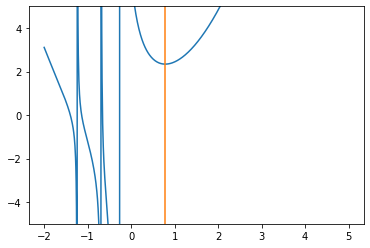

In [40]:
def test():
    c = torch.randn(4)
    x = torch.randn(4, requires_grad=True)
    f = -sum(torch.log(torch.sigmoid(x @ torch.randn(4))) for _ in range(10))
    A = hessian(f, x)
    gamma = 1

    T, U = utu_decomposition(A)
    print('A =', A, '\n')
    print('T =', T, '\n')
    print('U =', U, '\n')
    print('U @ T @ U.T =', U @ T @ U.T, '\n')

    tau = solve_auxilary_subproblem(T, c, gamma, 0.1)
    print('tau =', tau, '\n')

    xx = np.linspace(-2, 5, 1000)
    y = [auxilary_subproblem_objective(x, T, c, gamma) for x in xx]
    plt.plot(xx, y)
    plt.ylim(-5, 5)
    plt.plot([tau, tau], [-5, 5])

test()

A = tensor([[0.9407, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5929, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1349, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.6754]]) 

c = tensor([ 0.0000, 10.4709,  0.0000,  0.0000]) 

gamma = tensor([66.1202]) 

h = tensor([ 0.0000, -0.5355,  0.0000,  0.0000], grad_fn=<MvBackward>)


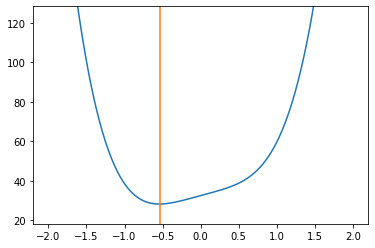

In [41]:
def test():
    A = torch.diag(torch.abs(torch.randn(4)))
    k = 1
    e_k = torch.zeros(4)
    e_k[k] = 1
    c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
    gamma = 100 * torch.abs(torch.randn(1))

    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')

    h = solve_auxilary_problem(A, c, gamma)
    print('h =', h)

    def f(h):
        return c @ h + .5 * c.T @ A @ c + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

test()

A = tensor([[2.9651, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0539, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2919, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0596]]) 

c = tensor([ 0.0000, 20.1661,  0.0000,  0.0000]) 

gamma = tensor([119.1427]) 

h = tensor([ 5.4151e-18, -5.4783e-01,  8.7143e-17,  1.1090e-16],
       requires_grad=True)


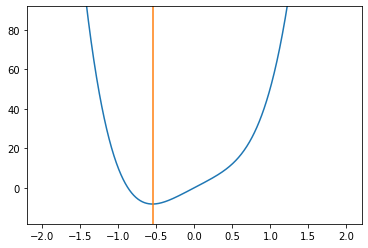

In [42]:
def test():
    A = torch.diag(torch.abs(torch.randn(4)))
    k = 1
    e_k = torch.zeros(4)
    e_k[k] = 1
    c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
    gamma = 100 * torch.abs(torch.randn(1))

    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')

    h = solve_auxilary_problem_dummy(A, c, gamma)
    print('h =', h)

    def f(h):
        return c @ h + .5 * h.T @ A @ h + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

test()

# Bregman-distance gradient method

In [396]:
def BDGM(f, x_tilda_k, delta, L3):
    
    f_x_tilda_k = f(x_tilda_k)
    g = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
    h = hessian(f_x_tilda_k, x_tilda_k)
    d3 = D3(f_x_tilda_k, x_tilda_k)
    def phi_k(z):
        y = z - x_tilda_k
        return g @ y + h @ y @ y + d3 @ y @ y @ y + L3 * torch.norm(y)**4 / 4
    
    grad_f_x_tilda_k = torch.autograd.grad([f(x_tilda_k)], [x_tilda_k], create_graph=True)[0]
    
    z_0 = x_tilda_k
    tau = 3 * delta / (8 * (2 + math.sqrt(2)) * torch.norm(grad_f_x_tilda_k))
    print('tau', tau)
    
    def D2v(z):
        return hessian_vector_product(f(x_tilda_k), x_tilda_k, z - x_tilda_k, True)
    
    def rho_k(z):
        '''
        Scaling function
        '''
        return .5 * D2v(z) @ (z - x_tilda_k) \
               + L3 * d_p(z - x_tilda_k, 4)
    
    def beta_rho_k(z_i, z):
        '''
        Bregman distance
        '''
        grad_rho_k = torch.autograd.grad([rho_k(z_i)], [z_i], create_graph=True, retain_graph=True)[0]
        return rho_k(z) - rho_k(z_i) - grad_rho_k @ (z - z_i)
    
    def g_x_tilda_k_tau(z):
        x_p = x_tilda_k + tau * (z - x_tilda_k)
        grad_g_p = torch.autograd.grad([f(x_p)], [x_p], create_graph=True, retain_graph=True)[0]
        x_n = x_tilda_k - tau * (z - x_tilda_k)
        grad_g_n = torch.autograd.grad([f(x_n)], [x_n], create_graph=True, retain_graph=True)[0]
        r = 1 / tau**2 * (grad_g_p + grad_g_n - 2 * grad_f_x_tilda_k)
#         print('r.norm', torch.norm(r))
        return r
    
    def g_phi_k_tau(z):
        return grad_f_x_tilda_k + D2v(z) + g_x_tilda_k_tau(z) + L3 * ((z - x_tilda_k)**2).sum() * (z - x_tilda_k)
    
    def auxilary_subproblem_dummy_objective(z, g_phi_k_tau_z_i, z_i): 
        value = g_phi_k_tau_z_i @ (z - z_i) + 2 * (1 + 2**(-.5))*beta_rho_k(z_i, z)
        return value
    
    def solve_auxilary_problem_dummy(g_phi_k_tau_z_i, z_i, learning_rate=0.001):
        z = torch.clone(z_i)
        z.requires_grad_()
        for i in range(100): 
            value = auxilary_subproblem_dummy_objective(z, g_phi_k_tau_z_i, z_i)
            grad = gradient(value, z)
            with torch.no_grad():
                z -= learning_rate * grad
        return z
    
    i = 0
    z_i = z_0
    while True:
        g_phi_k_tau_z_i = g_phi_k_tau(z_i)
        grad_f_z_i = torch.autograd.grad([f(z_i)], [z_i], create_graph=True)[0]
        print(i, z_i, phi_k(z_i).item(), torch.norm(g_phi_k_tau_z_i).item(), (1 / 6 * torch.norm(grad_f_z_i) - delta).item())
        if torch.norm(g_phi_k_tau_z_i) <= 1 / 6 * torch.norm(grad_f_z_i) - delta:
            break
        else:
            z_i = solve_auxilary_problem_dummy(g_phi_k_tau_z_i, z_i, 0.01)
        i += 1
    return z_i

In [352]:
x_tilda_k = torch.randn(31, requires_grad=True)

In [353]:
x_tilda_k

tensor([-1.1252,  0.2003, -1.1527, -0.6896,  0.2133, -0.5183,  0.5093,  0.0663,
         0.0659,  2.3175,  0.9387,  1.7266,  0.3160, -1.7770,  0.6436, -0.8246,
        -0.3027,  0.4885,  0.2035, -0.3205, -0.3450,  1.4428, -0.1534, -0.4447,
        -0.3153,  1.6758,  1.7388, -0.0659, -0.3670, -0.9805, -1.6353],
       requires_grad=True)

In [354]:
def test():
    def f(x):
        return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)

    f_x_tilda_k = f(x_tilda_k)
    g = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
    h = hessian(f_x_tilda_k, x_tilda_k)
    d3 = D3(f_x_tilda_k, x_tilda_k)
    
    print(g, torch.norm(g))
    print(h)
    print(d3)
    
    L3 = 5
    eps = 1e-5
#     delta = eps**1.5 / (torch.norm(g)**0.5 + torch.norm(h)**1.5 / L3**0.5)
    delta = 1e-9
    print('delta', delta)
    
    def phi_k(z):
        y = z - x_tilda_k
        return g @ y + h @ y @ y + d3 @ y @ y @ y + L3 * torch.norm(y)**4 / 4

    def is_feasible(z):
        return torch.norm(z - x_tilda_k) <= 2 * ((2 + math.sqrt(2)) * torch.norm(g) / L3) ** (1/3)

    z_opt = BDGM(f, x_tilda_k, delta, L3)
    print('z_opt =', z_opt)
    print('z_opt is feasible:', is_feasible(z_opt))
    
    print('phi_k(z_opt) =', phi_k(z_opt))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-1))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-2))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-3))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-4))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-5))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-6))
    print('z_opt is optimal:', check_optimality(phi_k, z_opt, eps=1e-7))

test()

tensor([ 0.1147,  0.3197,  0.1548,  0.1411,  0.2190,  0.3487,  0.3713,  0.3508,
         0.2688,  0.2545,  0.2786,  0.2425,  0.2793,  0.0821,  0.1657,  0.2658,
         0.2019,  0.3104,  0.1281,  0.1555,  0.2359,  0.3674,  0.2378,  0.1910,
         0.2669,  0.4052,  0.4393,  0.3649,  0.2237,  0.2151, -0.2252]) tensor(1.4886)
tensor([[ 7.0545e-02,  2.3000e-02,  2.4528e-02,  3.5057e-02,  1.3798e-02,
          1.3420e-02,  1.9035e-02,  3.1425e-02,  5.1852e-03, -1.7990e-03,
          2.5105e-02,  3.6819e-03,  1.8661e-02,  6.2723e-03, -3.2671e-03,
          3.1880e-03,  8.3437e-03,  1.0549e-02, -2.0868e-04, -1.4022e-03,
          2.4520e-02,  1.8517e-02,  2.0029e-02,  2.4423e-02,  3.6245e-03,
          2.0408e-02,  2.2246e-02,  2.3501e-02,  8.1489e-03, -7.1592e-03,
         -2.3385e-03],
        [ 2.3000e-02,  1.1603e-01,  2.2343e-02,  2.8510e-02,  3.0003e-04,
          3.0098e-02,  1.3168e-02,  3.9333e-02,  7.4545e-03, -1.4650e-02,
          1.7245e-02,  2.2071e-03,  1.7691e-02,  6.2169e-0

r.norm tensor(0., grad_fn=<NormBackward0>)
1 tensor([-1.1478,  0.1133, -1.1842, -0.7125,  0.1551, -0.6033,  0.4088, -0.0208,
        -0.0103,  2.2337,  0.8609,  1.6428,  0.2398, -1.7924,  0.5888, -0.8943,
        -0.3563,  0.4021,  0.1618, -0.3602, -0.4000,  1.3341, -0.2115, -0.4889,
        -0.3875,  1.5606,  1.6164, -0.1646, -0.4235, -1.0372, -1.5599],
       grad_fn=<CloneBackward>) -0.4958208203315735 0.956512451171875 0.21661750972270966
r.norm tensor(0., grad_fn=<NormBackward0>)
2 tensor([-1.1536,  0.0951, -1.1922, -0.7193,  0.1427, -0.6224,  0.3877, -0.0401,
        -0.0259,  2.2180,  0.8448,  1.6276,  0.2239, -1.7965,  0.5786, -0.9092,
        -0.3677,  0.3843,  0.1540, -0.3689, -0.4127,  1.3125, -0.2245, -0.4991,
        -0.4027,  1.5371,  1.5911, -0.1854, -0.4359, -1.0494, -1.5459],
       grad_fn=<CloneBackward>) -0.5486671328544617 0.6559135913848877 0.2093626856803894
r.norm tensor(0., grad_fn=<NormBackward0>)
3 tensor([-1.1565,  0.0854, -1.1961, -0.7224,  0.1362, -0.6323,

# Hyperfast Second-Order Method

In [402]:
import numpy as np

def square_norm(x):
    return torch.sum(torch.tensor(x)**2)

def hyperfast_second_order_method(f, y_0, K, L3, eps):
    '''
    Algorithm 2: Hyperfast Second-Order Method
    '''
    A_0 = 0
    x_0 = y_0 
    x_tilda_k = x_0
    A_k = A_0
    x_k = x_0
    y_k = y_0
    for k in range(K):
        f_x_tilda_k = f(x_tilda_k)
        g = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
        h = hessian(f_x_tilda_k, x_tilda_k)
        delta = 0.01 * eps**1.5 / (torch.norm(g)**0.5 + torch.norm(h)**1.5 / L3**0.5)
        y_k_plus_1 = BDGM(f, x_tilda_k, delta, L3)
        y_k_plus_1.requires_grad_()
        lambda_min = 2 / (3 * L3 * square_norm(y_k_plus_1 - x_tilda_k))
        lambda_max = 1 / (L3 * square_norm(y_k_plus_1 - x_tilda_k))
        lambda_k_plus_1 = (lambda_min + lambda_max) / 2
        a_k_plus_1 = 1 / 2 * (lambda_k_plus_1 +
                              (lambda_k_plus_1 ** 2 +
                               4 * lambda_k_plus_1 * A_k) ** 0.5)
        A_k_plus_1 = a_k_plus_1 + A_k
        x_tilda_k = A_k * y_k / A_k_plus_1 + a_k_plus_1 * x_k / A_k_plus_1
        x_k = x_k - a_k_plus_1 * torch.autograd.grad([f(y_k_plus_1)],
                                                     [y_k_plus_1],
                                                     create_graph=True)[0]
        A_k = A_k_plus_1
        y_k = y_k_plus_1
        print(f(y_k))
    return y_k

In [357]:
y_0 = torch.randn(31, requires_grad=True)

In [358]:
y_0

tensor([ 1.2459,  1.5047, -0.3683,  0.0547, -0.3496,  0.8307, -0.1385, -2.2468,
         1.1412, -1.3716, -0.1884,  0.6443, -0.1088, -1.4843, -0.6598,  0.9914,
        -0.2906, -1.3789,  1.6408,  0.0270,  0.0220,  0.2019,  2.0038, -1.2090,
         1.3530,  0.6028, -0.5950, -0.6647,  2.0260,  2.2036,  0.7997],
       requires_grad=True)

In [403]:
def test():
    L3 = 5
    eps = 1e-5
    delta = 1e-9
    K = 100
    
    def f(x):
        return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)
    
    y_opt = hyperfast_second_order_method(f, y_0, K, L3, eps)
    
    print('y_opt', y_opt)
    print('f(y_opt) =', f(y_opt))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-1))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-2))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-3))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-4))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-5))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-6))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-7))

test()

tau tensor(1.2290e-11, grad_fn=<DivBackward0>)
0 tensor([ 1.2459,  1.5047, -0.3683,  0.0547, -0.3496,  0.8307, -0.1385, -2.2468,
         1.1412, -1.3716, -0.1884,  0.6443, -0.1088, -1.4843, -0.6598,  0.9914,
        -0.2906, -1.3789,  1.6408,  0.0270,  0.0220,  0.2019,  2.0038, -1.2090,
         1.3530,  0.6028, -0.5950, -0.6647,  2.0260,  2.2036,  0.7997],
       requires_grad=True) 0.0 1.753929853439331 0.29232165217399597
1 tensor([ 1.1688,  1.3982, -0.4417, -0.0266, -0.4012,  0.7196, -0.2177, -2.3095,
         1.0462, -1.3651, -0.2459,  0.6283, -0.1722, -1.5117, -0.6573,  0.9187,
        -0.3165, -1.4026,  1.5925,  0.0085, -0.0606,  0.1112,  1.8824, -1.2687,
         1.2376,  0.4998, -0.6839, -0.7612,  1.8736,  2.1011,  0.8251],
       grad_fn=<CloneBackward>) -0.6101261377334595 1.1395728588104248 0.253595232963562
2 tensor([ 1.1522,  1.3777, -0.4577, -0.0442, -0.4125,  0.6968, -0.2356, -2.3244,
         1.0273, -1.3643, -0.2587,  0.6256, -0.1859, -1.5186, -0.6571,  0.9040,
     

/home/ivb/miniconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


1 tensor([ 1.1688,  1.3982, -0.4417, -0.0266, -0.4012,  0.7196, -0.2177, -2.3095,
         1.0462, -1.3651, -0.2459,  0.6283, -0.1722, -1.5117, -0.6573,  0.9187,
        -0.3165, -1.4026,  1.5925,  0.0085, -0.0606,  0.1112,  1.8824, -1.2687,
         1.2376,  0.4998, -0.6839, -0.7612,  1.8736,  2.1011,  0.8251],
       grad_fn=<CloneBackward>) -0.6101261377334595 1.1395728588104248 0.253595232963562
2 tensor([ 1.1522,  1.3777, -0.4577, -0.0442, -0.4125,  0.6968, -0.2356, -2.3244,
         1.0273, -1.3643, -0.2587,  0.6256, -0.1859, -1.5186, -0.6571,  0.9040,
        -0.3226, -1.4091,  1.5836,  0.0040, -0.0788,  0.0932,  1.8579, -1.2826,
         1.2148,  0.4785, -0.7028, -0.7824,  1.8447,  2.0810,  0.8306],
       grad_fn=<CloneBackward>) -0.661476194858551 0.7845706343650818 0.2443210333585739
3 tensor([ 1.1435e+00,  1.3663e+00, -4.6611e-01, -5.3452e-02, -4.1843e-01,
         6.8461e-01, -2.4477e-01, -2.3319e+00,  1.0170e+00, -1.3638e+00,
        -2.6541e-01,  6.2403e-01, -1.9316e-01,

5 tensor([ 0.9696,  1.1107, -0.6167, -0.2365, -0.5243,  0.4273, -0.3983, -2.4332,
         0.7817, -1.3319, -0.3874,  0.5718, -0.3297, -1.5449, -0.6418,  0.7440,
        -0.3590, -1.4377,  1.4398, -0.0252, -0.2829, -0.1243,  1.5450, -1.3993,
         0.9179,  0.2371, -0.8956, -0.9933,  1.4412,  1.8197,  0.9114],
       grad_fn=<CloneBackward>) -0.28157150745391846 0.15619975328445435 0.14537708461284637
6 tensor([ 0.9678,  1.1078, -0.6179, -0.2383, -0.5252,  0.4247, -0.3993, -2.4334,
         0.7790, -1.3313, -0.3884,  0.5711, -0.3309, -1.5446, -0.6416,  0.7426,
        -0.3590, -1.4373,  1.4380, -0.0252, -0.2848, -0.1265,  1.5417, -1.3999,
         0.9147,  0.2349, -0.8970, -0.9949,  1.4367,  1.8169,  0.9124],
       grad_fn=<CloneBackward>) -0.2757776379585266 0.10784441977739334 0.14470221102237701
tensor(1.8616, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(3.9288e-11, grad_fn=<DivBackward0>)
0 tensor([ 0.9402,  1.0733, -0.6587, -0.2730, -0.5473,  0.3750, -0.4422, -2.4

4 tensor([ 0.6493,  0.5871, -0.8217, -0.5661, -0.6378, -0.0341, -0.6216, -2.4707,
         0.3366, -1.1887, -0.5742,  0.4658, -0.5531, -1.5337, -0.5932,  0.4953,
        -0.2982, -1.3610,  1.1434, -0.0174, -0.6446, -0.5426,  0.9432, -1.5524,
         0.3282, -0.1581, -1.1694, -1.3135,  0.5716,  1.3175,  1.0718],
       grad_fn=<CloneBackward>) -0.09480578452348709 0.09132491797208786 0.054653268307447433
5 tensor([ 0.6472,  0.5840, -0.8217, -0.5677, -0.6371, -0.0361, -0.6213, -2.4679,
         0.3343, -1.1858, -0.5746,  0.4651, -0.5538, -1.5329, -0.5920,  0.4942,
        -0.2957, -1.3588,  1.1410, -0.0159, -0.6463, -0.5448,  0.9392, -1.5524,
         0.3248, -0.1593, -1.1695, -1.3139,  0.5646,  1.3148,  1.0727],
       grad_fn=<CloneBackward>) -0.09481805562973022 0.06369464099407196 0.05435606837272644
6 tensor([ 0.6457,  0.5820, -0.8215, -0.5688, -0.6365, -0.0373, -0.6210, -2.4659,
         0.3329, -1.1838, -0.5749,  0.4646, -0.5543, -1.5324, -0.5911,  0.4934,
        -0.2940, -1.357

3 tensor([ 0.2924,  0.0171, -0.9329, -0.8726, -0.6056, -0.4198, -0.6725, -2.2148,
        -0.0301, -0.8579, -0.7235,  0.3562, -0.7450, -1.4596, -0.4437,  0.2852,
        -0.0106, -1.1007,  0.7906,  0.1851, -0.9586, -0.9374,  0.2969, -1.6072,
        -0.2645, -0.4493, -1.2816, -1.5117, -0.4485,  0.8565,  1.2640],
       grad_fn=<CloneBackward>) -0.034060295671224594 0.07597076147794724 0.025896236300468445
4 tensor([ 0.2889,  0.0126, -0.9319, -0.8734, -0.6027, -0.4196, -0.6682, -2.2069,
        -0.0285, -0.8514, -0.7247,  0.3555, -0.7459, -1.4575, -0.4392,  0.2845,
        -0.0036, -1.0950,  0.7885,  0.1927, -0.9585, -0.9377,  0.2924, -1.6049,
        -0.2670, -0.4480, -1.2782, -1.5101, -0.4544,  0.8559,  1.2662],
       grad_fn=<CloneBackward>) -0.035110022872686386 0.05374348536133766 0.02572258934378624
5 tensor([ 2.8676e-01,  9.7483e-03, -9.3116e-01, -8.7384e-01, -6.0091e-01,
        -4.1944e-01, -6.6544e-01, -2.2019e+00, -2.7497e-02, -8.4735e-01,
        -7.2549e-01,  3.5505e-01, -

7 tensor([ 0.0372, -0.3355, -0.9439, -1.0184, -0.4890, -0.5539, -0.5664, -1.8729,
        -0.1072, -0.5199, -0.8277,  0.2776, -0.8613, -1.3593, -0.2451,  0.1862,
         0.3155, -0.8244,  0.5946,  0.5086, -1.0804, -1.0951, -0.1062, -1.5627,
        -0.5620, -0.5149, -1.2109, -1.5352, -1.0023,  0.6750,  1.4065],
       grad_fn=<CloneBackward>) -0.024632593616843224 0.016522476449608803 0.019462358206510544
tensor(0.2829, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(7.9936e-10, grad_fn=<DivBackward0>)
0 tensor([-0.0404, -0.4586, -0.9525, -1.0724, -0.4612, -0.6135, -0.5403, -1.7787,
        -0.1634, -0.4202, -0.8561,  0.2542, -0.8913, -1.3375, -0.1894,  0.1553,
         0.4161, -0.7445,  0.5177,  0.5930, -1.1329, -1.1618, -0.2418, -1.5585,
        -0.6739, -0.5432, -1.2029, -1.5547, -1.2203,  0.5998,  1.4545],
       grad_fn=<AddBackward0>) 0.0 0.1100744754076004 0.018345747143030167
1 tensor([-0.0614, -0.4703, -0.9468, -1.0693, -0.4437, -0.6012, -0.5225, -1.7440,
        -

1 tensor([-0.3592, -0.7728, -0.9116, -1.1288, -0.2661, -0.6311, -0.3518, -1.2977,
        -0.0423,  0.0099, -1.0290,  0.1413, -1.0345, -1.1541,  0.0618,  0.0222,
         0.7620, -0.4275,  0.4041,  1.0442, -1.1588, -1.1919, -0.6487, -1.4022,
        -0.8614, -0.5090, -1.0054, -1.4741, -1.5144,  0.5306,  1.6029],
       grad_fn=<CloneBackward>) -0.0030241713393479586 0.054493341594934464 0.009220496751368046
2 tensor([-0.3707, -0.7729, -0.9076, -1.1164, -0.2608, -0.6337, -0.3512, -1.2847,
        -0.0342,  0.0129, -1.0438,  0.1392, -1.0382, -1.1437,  0.0551,  0.0069,
         0.7538, -0.4279,  0.4101,  1.0427, -1.1539, -1.1801, -0.6588, -1.3869,
        -0.8608, -0.5065, -0.9974, -1.4681, -1.4995,  0.5252,  1.6050],
       grad_fn=<CloneBackward>) -0.005312011111527681 0.04847387596964836 0.008949405513703823
3 tensor([-0.3790, -0.7729, -0.9045, -1.1068, -0.2569, -0.6355, -0.3506, -1.2749,
        -0.0282,  0.0152, -1.0544,  0.1376, -1.0405, -1.1356,  0.0502, -0.0039,
         0.7480, -

1 tensor([-0.6506, -0.9755, -0.8532, -1.0484, -0.1082, -0.6776, -0.2391, -0.8879,
         0.0803,  0.2969, -1.2605,  0.0523, -1.1447, -0.9439,  0.1533, -0.1950,
         0.8934, -0.2395,  0.3766,  1.2958, -1.1393, -1.1218, -1.0004, -1.1704,
        -0.9876, -0.4746, -0.8179, -1.3708, -1.5908,  0.4249,  1.7084],
       grad_fn=<CloneBackward>) -0.0037727844901382923 0.06059788912534714 0.010296853259205818
2 tensor([-0.6550, -0.9689, -0.8501, -1.0318, -0.1115, -0.6878, -0.2467, -0.8870,
         0.0802,  0.2903, -1.2749,  0.0552, -1.1427, -0.9381,  0.1388, -0.2082,
         0.8816, -0.2457,  0.3831,  1.2844, -1.1380, -1.1107, -1.0052, -1.1601,
        -0.9886, -0.4771, -0.8145, -1.3670, -1.5727,  0.4119,  1.7104],
       grad_fn=<CloneBackward>) -0.006144557613879442 0.05102235823869705 0.009616589173674583
3 tensor([-0.6582, -0.9643, -0.8477, -1.0198, -0.1134, -0.6943, -0.2514, -0.8858,
         0.0807,  0.2858, -1.2850,  0.0569, -1.1410, -0.9337,  0.1285, -0.2167,
         0.8734, -0

1 tensor([-0.8819, -1.0581, -0.7847, -0.8499, -0.0256, -0.7878, -0.2170, -0.5956,
         0.1657,  0.4406, -1.5318,  0.0134, -1.1933, -0.7491,  0.0942, -0.4361,
         0.8900, -0.1532,  0.4131,  1.3814, -1.1159, -0.9883, -1.2887, -0.9237,
        -1.0773, -0.4658, -0.6498, -1.2567, -1.4927,  0.2525,  1.7934],
       grad_fn=<CloneBackward>) -0.0024024697486311197 0.048490010201931 0.008186670020222664
2 tensor([-0.8822, -1.0506, -0.7830, -0.8348, -0.0314, -0.7956, -0.2248, -0.5987,
         0.1634,  0.4324, -1.5397,  0.0172, -1.1879, -0.7452,  0.0799, -0.4425,
         0.8791, -0.1589,  0.4184,  1.3704, -1.1158, -0.9824, -1.2933, -0.9169,
        -1.0768, -0.4683, -0.6466, -1.2502, -1.4771,  0.2429,  1.7946],
       grad_fn=<CloneBackward>) -0.0040765246376395226 0.04231170192360878 0.007680453360080719
3 tensor([-0.8823, -1.0448, -0.7816, -0.8228, -0.0356, -0.8010, -0.2302, -0.6007,
         0.1621,  0.4264, -1.5455,  0.0198, -1.1835, -0.7420,  0.0689, -0.4468,
         0.8708, -0.

10 tensor([-0.9676, -1.0342, -0.7424, -0.6569, -0.0285, -0.8711, -0.2501, -0.4968,
         0.1889,  0.4406, -1.6777,  0.0214, -1.1642, -0.6400, -0.0317, -0.5545,
         0.8076, -0.1529,  0.4659,  1.3434, -1.1018, -0.9036, -1.4407, -0.7685,
        -1.0951, -0.4678, -0.5487, -1.1455, -1.3478,  0.1310,  1.8264],
       grad_fn=<CloneBackward>) -0.004277015570551157 0.005652882158756256 0.005192154552787542
11 tensor([-0.9674, -1.0335, -0.7422, -0.6557, -0.0287, -0.8712, -0.2501, -0.4969,
         0.1890,  0.4401, -1.6777,  0.0216, -1.1635, -0.6397, -0.0327, -0.5543,
         0.8068, -0.1530,  0.4663,  1.3429, -1.1017, -0.9036, -1.4412, -0.7677,
        -1.0946, -0.4676, -0.5481, -1.1444, -1.3469,  0.1307,  1.8262],
       grad_fn=<CloneBackward>) -0.004277554340660572 0.0043368032202124596 0.005179352592676878
tensor(0.1449, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(5.2312e-09, grad_fn=<DivBackward0>)
0 tensor([-1.0702e+00, -1.0628e+00, -7.1128e-01, -5.5634e-01, -5.16

4 tensor([-1.1238, -1.0171, -0.6720, -0.3465, -0.0149, -0.9944, -0.2807, -0.3163,
         0.2232,  0.4688, -1.8985,  0.0268, -1.1219, -0.4594, -0.1971, -0.7216,
         0.7060, -0.1207,  0.5304,  1.3238, -1.0729, -0.7937, -1.7188, -0.4994,
        -1.1258, -0.4611, -0.3668, -0.9468, -1.1618, -0.0704,  1.8891],
       grad_fn=<CloneBackward>) -0.0017962916754186153 0.018863853067159653 0.0036510960198938847
5 tensor([-1.1214, -1.0148, -0.6719, -0.3428, -0.0156, -0.9924, -0.2799, -0.3196,
         0.2209,  0.4662, -1.8933,  0.0275, -1.1187, -0.4604, -0.1972, -0.7147,
         0.7043, -0.1198,  0.5294,  1.3229, -1.0713, -0.7981, -1.7199, -0.4971,
        -1.1227, -0.4597, -0.3648, -0.9411, -1.1637, -0.0712,  1.8883],
       grad_fn=<CloneBackward>) -0.002008892595767975 0.016444938257336617 0.003566971281543374
6 tensor([-1.1193, -1.0127, -0.6719, -0.3398, -0.0163, -0.9907, -0.2793, -0.3223,
         0.2191,  0.4640, -1.8890,  0.0282, -1.1160, -0.4612, -0.1974, -0.7091,
         0.7028,

10 tensor([-1.1673, -0.9837, -0.6429, -0.1759, -0.0157, -1.0274, -0.2872, -0.2730,
         0.2160,  0.4530, -1.9425,  0.0384, -1.0698, -0.3931, -0.2641, -0.7243,
         0.6452, -0.0973,  0.5507,  1.3093, -1.0402, -0.7914, -1.8491, -0.3637,
        -1.1061, -0.4459, -0.2689, -0.8033, -1.0967, -0.1718,  1.9103],
       grad_fn=<CloneBackward>) -0.0032516615465283394 0.005206190515309572 0.004411044996231794
11 tensor([-1.1668, -0.9832, -0.6430, -0.1758, -0.0158, -1.0268, -0.2870, -0.2738,
         0.2156,  0.4525, -1.9414,  0.0385, -1.0695, -0.3936, -0.2635, -0.7230,
         0.6451, -0.0969,  0.5503,  1.3093, -1.0396, -0.7922, -1.8488, -0.3638,
        -1.1056, -0.4457, -0.2688, -0.8025, -1.0972, -0.1719,  1.9101],
       grad_fn=<CloneBackward>) -0.003229791997000575 0.004006619565188885 0.0043855877593159676
tensor(0.1356, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(2.9319e-09, grad_fn=<DivBackward0>)
0 tensor([-1.2025, -0.9567, -0.6180, -0.0543, -0.0279, -1.0666, -0

6 tensor([-1.2045, -0.9354, -0.6190,  0.0292, -0.0059, -1.0342, -0.2837, -0.2481,
         0.1916,  0.4177, -1.9403,  0.0494, -0.9935, -0.3344, -0.3036, -0.6672,
         0.5573, -0.0576,  0.5520,  1.2965, -0.9693, -0.8391, -1.9989, -0.1997,
        -1.0502, -0.4177, -0.1463, -0.5959, -1.0565, -0.3075,  1.9321],
       grad_fn=<CloneBackward>) -0.0036237637978047132 0.014766511507332325 0.004864818882197142
7 tensor([-1.2035, -0.9350, -0.6199,  0.0272, -0.0057, -1.0321, -0.2831, -0.2504,
         0.1909,  0.4170, -1.9371,  0.0491, -0.9935, -0.3365, -0.3005, -0.6642,
         0.5574, -0.0572,  0.5505,  1.2970, -0.9677, -0.8414, -1.9969, -0.2015,
        -1.0489, -0.4175, -0.1471, -0.5955, -1.0588, -0.3074,  1.9317],
       grad_fn=<CloneBackward>) -0.003650289960205555 0.011485558934509754 0.004775498528033495
8 tensor([-1.2026, -0.9346, -0.6205,  0.0258, -0.0057, -1.0305, -0.2826, -0.2522,
         0.1904,  0.4164, -1.9347,  0.0489, -0.9936, -0.3381, -0.2983, -0.6621,
         0.5575, 

11 tensor([-1.1951e+00, -9.0371e-01, -6.2660e-01,  7.1647e-02, -5.1099e-04,
        -9.9604e-01, -2.7273e-01, -2.8711e-01,  1.7271e-01,  3.8480e-01,
        -1.8749e+00,  4.9308e-02, -9.5980e-01, -3.4910e-01, -2.6900e-01,
        -5.9168e-01,  5.1799e-01, -4.3077e-02,  5.2458e-01,  1.2936e+00,
        -9.1113e-01, -8.9820e-01, -2.0137e+00, -1.7173e-01, -9.9883e-01,
        -4.0302e-01, -1.1532e-01, -5.0706e-01, -1.0742e+00, -3.5420e-01,
         1.9263e+00], grad_fn=<CloneBackward>) -0.002995947375893593 0.00427333265542984 0.003959680907428265
12 tensor([-1.1948e+00, -9.0336e-01, -6.2680e-01,  7.0970e-02, -6.6014e-04,
        -9.9538e-01, -2.7257e-01, -2.8796e-01,  1.7272e-01,  3.8448e-01,
        -1.8741e+00,  4.9221e-02, -9.5983e-01, -3.4968e-01, -2.6839e-01,
        -5.9116e-01,  5.1797e-01, -4.3216e-02,  5.2419e-01,  1.2936e+00,
        -9.1055e-01, -8.9845e-01, -2.0129e+00, -1.7248e-01, -9.9848e-01,
        -4.0303e-01, -1.1560e-01, -5.0706e-01, -1.0744e+00, -3.5408e-01,
        

4 tensor([-1.1928, -0.8499, -0.6528,  0.1268,  0.0136, -0.9210, -0.2619, -0.3733,
         0.1468,  0.3213, -1.7543,  0.0421, -0.9094, -0.3856, -0.1912, -0.4659,
         0.4381, -0.0334,  0.4632,  1.2941, -0.7932, -1.0140, -2.0369, -0.1421,
        -0.9008, -0.3878, -0.0720, -0.3551, -1.1047, -0.4476,  1.9226],
       grad_fn=<CloneBackward>) -0.0019214311614632607 0.018474187701940536 0.0037060012109577656
5 tensor([-1.1927, -0.8486, -0.6543,  0.1212,  0.0127, -0.9187, -0.2628, -0.3776,
         0.1487,  0.3197, -1.7524,  0.0414, -0.9108, -0.3881, -0.1896, -0.4674,
         0.4370, -0.0372,  0.4619,  1.2934, -0.7914, -1.0129, -2.0316, -0.1480,
        -0.8998, -0.3892, -0.0753, -0.3581, -1.1027, -0.4459,  1.9209],
       grad_fn=<CloneBackward>) -0.0020856435876339674 0.015615045092999935 0.0035605530720204115
6 tensor([-1.1924, -0.8474, -0.6554,  0.1168,  0.0120, -0.9166, -0.2634, -0.3810,
         0.1502,  0.3186, -1.7508,  0.0407, -0.9118, -0.3900, -0.1882, -0.4684,
         0.436

10 tensor([-1.1919, -0.8103, -0.6794,  0.0917,  0.0113, -0.8590, -0.2648, -0.4561,
         0.1580,  0.2777, -1.6813,  0.0290, -0.9009, -0.4280, -0.1353, -0.4239,
         0.3942, -0.0693,  0.4235,  1.2930, -0.7202, -1.0541, -1.9917, -0.1936,
        -0.8488, -0.3961, -0.0882, -0.3219, -1.0974, -0.4718,  1.9036],
       grad_fn=<CloneBackward>) -0.002041954779997468 0.005532780196517706 0.002994278911501169
11 tensor([-1.1915, -0.8098, -0.6793,  0.0905,  0.0110, -0.8581, -0.2646, -0.4567,
         0.1586,  0.2774, -1.6808,  0.0287, -0.9008, -0.4283, -0.1350, -0.4241,
         0.3944, -0.0700,  0.4235,  1.2930, -0.7199, -1.0533, -1.9900, -0.1949,
        -0.8489, -0.3962, -0.0889, -0.3228, -1.0967, -0.4710,  1.9027],
       grad_fn=<CloneBackward>) -0.0020429003052413464 0.004495006520301104 0.0029713574331253767
12 tensor([-1.1911, -0.8093, -0.6792,  0.0895,  0.0108, -0.8574, -0.2644, -0.4571,
         0.1591,  0.2772, -1.6803,  0.0285, -0.9006, -0.4286, -0.1347, -0.4242,
         0.39

14 tensor([-1.1706e+00, -7.5836e-01, -6.9501e-01,  4.3798e-02,  1.1709e-03,
        -7.9124e-01, -2.6140e-01, -5.3315e-01,  1.7711e-01,  2.3313e-01,
        -1.6035e+00,  1.5700e-02, -8.8258e-01, -4.6666e-01, -8.7580e-02,
        -3.9067e-01,  3.5684e-01, -1.1406e-01,  3.9316e-01,  1.2813e+00,
        -6.5681e-01, -1.0678e+00, -1.9148e+00, -2.5584e-01, -8.0311e-01,
        -4.0352e-01, -1.1457e-01, -3.0915e-01, -1.0737e+00, -4.7148e-01,
         1.8621e+00], grad_fn=<CloneBackward>) -0.0015852166106924415 0.0026695376727730036 0.00247276877053082
15 tensor([-1.1701e+00, -7.5804e-01, -6.9471e-01,  4.3332e-02,  1.0546e-03,
        -7.9087e-01, -2.6116e-01, -5.3305e-01,  1.7733e-01,  2.3310e-01,
        -1.6032e+00,  1.5493e-02, -8.8228e-01, -4.6665e-01, -8.7523e-02,
        -3.9077e-01,  3.5704e-01, -1.1423e-01,  3.9323e-01,  1.2813e+00,
        -6.5686e-01, -1.0672e+00, -1.9140e+00, -2.5625e-01, -8.0322e-01,
        -4.0355e-01, -1.1484e-01, -3.0963e-01, -1.0734e+00, -4.7101e-01,
      

14 tensor([-1.1567e+00, -7.0748e-01, -7.0322e-01,  6.5515e-04, -9.0491e-03,
        -7.3024e-01, -2.5956e-01, -5.9732e-01,  2.0180e-01,  1.9395e-01,
        -1.5438e+00, -4.0024e-04, -8.6497e-01, -4.9619e-01, -4.7794e-02,
        -3.7306e-01,  3.2436e-01, -1.6040e-01,  3.6992e-01,  1.2773e+00,
        -6.0130e-01, -1.0674e+00, -1.8472e+00, -3.1529e-01, -7.6875e-01,
        -4.1543e-01, -1.3994e-01, -3.0493e-01, -1.0400e+00, -4.7245e-01,
         1.8244e+00], grad_fn=<CloneBackward>) -0.0013245530426502228 0.002933909185230732 0.0021874485537409782
15 tensor([-1.1562e+00, -7.0717e-01, -7.0273e-01,  3.4643e-04, -9.1572e-03,
        -7.3002e-01, -2.5926e-01, -5.9693e-01,  2.0196e-01,  1.9399e-01,
        -1.5436e+00, -6.2189e-04, -8.6453e-01, -4.9599e-01, -4.7926e-02,
        -3.7327e-01,  3.2466e-01, -1.6046e-01,  3.7002e-01,  1.2772e+00,
        -6.0158e-01, -1.0667e+00, -1.8464e+00, -3.1551e-01, -7.6893e-01,
        -4.1544e-01, -1.4016e-01, -3.0547e-01, -1.0396e+00, -4.7188e-01,
     

16 tensor([-1.1180, -0.6464, -0.6924, -0.0518, -0.0241, -0.6652, -0.2474, -0.6440,
         0.2307,  0.1573, -1.4784, -0.0195, -0.8315, -0.5168, -0.0179, -0.3640,
         0.3029, -0.2089,  0.3544,  1.2622, -0.5610, -1.0370, -1.7468, -0.3789,
        -0.7418, -0.4256, -0.1737, -0.3219, -0.9918, -0.4471,  1.7613],
       grad_fn=<CloneBackward>) -0.0012089863885194063 0.0021284115500748158 0.002043161541223526
17 tensor([-1.1176, -0.6463, -0.6920, -0.0519, -0.0241, -0.6652, -0.2472, -0.6435,
         0.2307,  0.1573, -1.4782, -0.0196, -0.8311, -0.5166, -0.0181, -0.3641,
         0.3032, -0.2088,  0.3544,  1.2620, -0.5613, -1.0365, -1.7463, -0.3789,
        -0.7418, -0.4256, -0.1738, -0.3223, -0.9916, -0.4467,  1.7609],
       grad_fn=<CloneBackward>) -0.0012069020885974169 0.0017697724979370832 0.0020376164466142654
tensor(0.1252, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(9.3266e-09, grad_fn=<DivBackward0>)
0 tensor([-1.1139, -0.5977, -0.7117, -0.1053, -0.0392, -0.6086,

17 tensor([-1.0806e+00, -5.9322e-01, -6.6780e-01, -9.0829e-02, -3.4882e-02,
        -6.1283e-01, -2.3241e-01, -6.6474e-01,  2.5572e-01,  1.3100e-01,
        -1.4288e+00, -4.0925e-02, -7.9333e-01, -5.2330e-01, -5.2627e-04,
        -3.6352e-01,  2.9267e-01, -2.4510e-01,  3.4495e-01,  1.2521e+00,
        -5.3800e-01, -9.9692e-01, -1.6607e+00, -4.2650e-01, -7.2684e-01,
        -4.3571e-01, -2.0130e-01, -3.4375e-01, -9.4472e-01, -4.2102e-01,
         1.7028e+00], grad_fn=<CloneBackward>) -0.0011863987892866135 0.0017751699779182673 0.0020175331737846136
tensor(0.1246, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(9.1512e-09, grad_fn=<DivBackward0>)
0 tensor([-1.0541, -0.5344, -0.6657, -0.1455, -0.0541, -0.5531, -0.2277, -0.7173,
         0.2928,  0.0954, -1.3794, -0.0551, -0.7724, -0.5447,  0.0241, -0.3687,
         0.2687, -0.3039,  0.3373,  1.2391, -0.4962, -0.9620, -1.5683, -0.4954,
        -0.7059, -0.4491, -0.2362, -0.3659, -0.8891, -0.3979,  1.6471],
       grad_fn=<AddBa

1 tensor([-0.9884, -0.4887, -0.6008, -0.1632, -0.0568, -0.5167, -0.1942, -0.6767,
         0.3029,  0.0884, -1.3361, -0.0825, -0.7055, -0.5219,  0.0187, -0.3713,
         0.2855, -0.3079,  0.3371,  1.2226, -0.5142, -0.8944, -1.4785, -0.5083,
        -0.7083, -0.4514, -0.2555, -0.4005, -0.8450, -0.3511,  1.5737],
       grad_fn=<CloneBackward>) -0.00023398437770083547 0.015238333493471146 0.002542078262194991
2 tensor([-0.9854, -0.4909, -0.5973, -0.1608, -0.0548, -0.5190, -0.1928, -0.6709,
         0.2989,  0.0902, -1.3345, -0.0831, -0.7028, -0.5193,  0.0167, -0.3696,
         0.2876, -0.3030,  0.3354,  1.2201, -0.5184, -0.8947, -1.4785, -0.5040,
        -0.7078, -0.4503, -0.2545, -0.4003, -0.8480, -0.3499,  1.5728],
       grad_fn=<CloneBackward>) -0.0004307031340431422 0.014392874203622341 0.0024184267967939377
3 tensor([-0.9826, -0.4930, -0.5939, -0.1585, -0.0529, -0.5212, -0.1916, -0.6655,
         0.2953,  0.0918, -1.3331, -0.0836, -0.7003, -0.5168,  0.0147, -0.3682,
         0.289

tau tensor(1.0079e-08, grad_fn=<DivBackward0>)
0 tensor([-0.9114, -0.4492, -0.5297, -0.1768, -0.0548, -0.4875, -0.1597, -0.6235,
         0.3011,  0.0847, -1.2836, -0.1066, -0.6339, -0.4932,  0.0054, -0.3702,
         0.3046, -0.3009,  0.3318,  1.1859, -0.5431, -0.8261, -1.3795, -0.5111,
        -0.7025, -0.4487, -0.2741, -0.4350, -0.8047, -0.2976,  1.4936],
       grad_fn=<AddBackward0>) 0.0 0.014819901436567307 0.0024699822533875704
1 tensor([-0.9099, -0.4526, -0.5282, -0.1746, -0.0522, -0.4905, -0.1600, -0.6194,
         0.2963,  0.0863, -1.2816, -0.1062, -0.6332, -0.4913,  0.0029, -0.3687,
         0.3053, -0.2965,  0.3290,  1.1813, -0.5466, -0.8283, -1.3801, -0.5072,
        -0.7002, -0.4479, -0.2733, -0.4341, -0.8080, -0.2976,  1.4939],
       grad_fn=<CloneBackward>) -0.00019703406724147499 0.013976574875414371 0.002331752795726061
2 tensor([-9.0854e-01, -4.5585e-01, -5.2673e-01, -1.7248e-01, -4.9712e-02,
        -4.9343e-01, -1.6027e-01, -6.1550e-01,  2.9183e-01,  8.7833e-02,
 

tau tensor(1.0629e-08, grad_fn=<DivBackward0>)
0 tensor([-0.8368, -0.4324, -0.4545, -0.1724, -0.0381, -0.4796, -0.1306, -0.5486,
         0.2749,  0.0926, -1.2306, -0.1242, -0.5663, -0.4534, -0.0221, -0.3636,
         0.3282, -0.2685,  0.3164,  1.1280, -0.5903, -0.7716, -1.2963, -0.4902,
        -0.6862, -0.4408, -0.2840, -0.4619, -0.7820, -0.2502,  1.4238],
       grad_fn=<AddBackward0>) 0.0 0.013716686517000198 0.0022861131001263857
1 tensor([-0.8373, -0.4362, -0.4558, -0.1709, -0.0357, -0.4826, -0.1327, -0.5472,
         0.2707,  0.0940, -1.2292, -0.1221, -0.5684, -0.4526, -0.0242, -0.3627,
         0.3272, -0.2658,  0.3140,  1.1218, -0.5921, -0.7745, -1.2970, -0.4877,
        -0.6826, -0.4400, -0.2833, -0.4606, -0.7840, -0.2512,  1.4251],
       grad_fn=<CloneBackward>) -0.00016633281484246254 0.01283260714262724 0.0021412228234112263
2 tensor([-0.8378, -0.4397, -0.4569, -0.1694, -0.0335, -0.4854, -0.1346, -0.5459,
         0.2668,  0.0955, -1.2279, -0.1201, -0.5705, -0.4517, -0.02

20 tensor([-0.8401, -0.4634, -0.4649, -0.1537, -0.0201, -0.5042, -0.1463, -0.5311,
         0.2400,  0.1101, -1.2206, -0.1005, -0.5879, -0.4426, -0.0356, -0.3539,
         0.3259, -0.2417,  0.3046,  1.0741, -0.6034, -0.7873, -1.3010, -0.4653,
        -0.6580, -0.4274, -0.2734, -0.4513, -0.7951, -0.2565,  1.4305],
       grad_fn=<CloneBackward>) -0.0007142018876038492 0.0012423066655173898 0.0013365059858188033
tensor(0.1214, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(9.9926e-09, grad_fn=<DivBackward0>)
0 tensor([-0.7620, -0.4320, -0.3889, -0.1606, -0.0122, -0.4842, -0.1124, -0.4678,
         0.2287,  0.1088, -1.1677, -0.1251, -0.5133, -0.4092, -0.0565, -0.3513,
         0.3473, -0.2241,  0.2936,  1.0313, -0.6419, -0.7253, -1.2084, -0.4580,
        -0.6493, -0.4244, -0.2897, -0.4831, -0.7639, -0.2047,  1.3547],
       grad_fn=<AddBackward0>) 0.0 0.013948146253824234 0.0023246898781508207
1 tensor([-0.7645, -0.4351, -0.3929, -0.1600, -0.0107, -0.4862, -0.1156, -0.4694,
  

19 tensor([-0.7815, -0.4584, -0.4226, -0.1495, -0.0039, -0.5007, -0.1359, -0.4747,
         0.2056,  0.1254, -1.1638, -0.0921, -0.5571, -0.4092, -0.0554, -0.3448,
         0.3368, -0.2154,  0.2899,  0.9847, -0.6314, -0.7406, -1.2174, -0.4471,
        -0.6242, -0.4099, -0.2797, -0.4702, -0.7686, -0.2192,  1.3666],
       grad_fn=<CloneBackward>) -0.0006902816239744425 0.001361398957669735 0.0012845284072682261
20 tensor([-0.7816, -0.4587, -0.4229, -0.1493, -0.0039, -0.5008, -0.1360, -0.4745,
         0.2053,  0.1256, -1.1637, -0.0918, -0.5575, -0.4091, -0.0553, -0.3447,
         0.3368, -0.2152,  0.2899,  0.9843, -0.6312, -0.7406, -1.2175, -0.4468,
        -0.6242, -0.4096, -0.2795, -0.4700, -0.7687, -0.2192,  1.3666],
       grad_fn=<CloneBackward>) -0.0006889640353620052 0.0011750367702916265 0.0012794974027201533
tensor(0.1211, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(9.2051e-09, grad_fn=<DivBackward0>)
0 tensor([-0.7147, -0.4506, -0.3554, -0.1414,  0.0158, -0.5006,

18 tensor([-0.7422, -0.4667, -0.4014, -0.1391,  0.0110, -0.5059, -0.1364, -0.4266,
         0.1675,  0.1474, -1.1172, -0.0710, -0.5507, -0.3801, -0.0706, -0.3356,
         0.3446, -0.1885,  0.2781,  0.8944, -0.6494, -0.7054, -1.1554, -0.4238,
        -0.5908, -0.3876, -0.2794, -0.4804, -0.7501, -0.1951,  1.3185],
       grad_fn=<CloneBackward>) -0.0007138863438740373 0.0014715483412146568 0.001310849911533296
19 tensor([-0.7424, -0.4669, -0.4018, -0.1389,  0.0109, -0.5060, -0.1366, -0.4266,
         0.1673,  0.1475, -1.1172, -0.0707, -0.5512, -0.3801, -0.0704, -0.3355,
         0.3445, -0.1885,  0.2781,  0.8942, -0.6490, -0.7055, -1.1557, -0.4235,
        -0.5909, -0.3873, -0.2792, -0.4801, -0.7502, -0.1952,  1.3186],
       grad_fn=<CloneBackward>) -0.000712150358594954 0.0012603247305378318 0.0013043201761320233
tensor(0.1211, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(9.2822e-09, grad_fn=<DivBackward0>)
0 tensor([-0.6848, -0.4732, -0.3546, -0.1262,  0.0356, -0.5140, 

18 tensor([-0.7134, -0.4799, -0.4017, -0.1301,  0.0197, -0.5102, -0.1451, -0.3905,
         0.1300,  0.1722, -1.0708, -0.0391, -0.5635, -0.3576, -0.0753, -0.3247,
         0.3458, -0.1683,  0.2688,  0.8020, -0.6501, -0.6739, -1.0997, -0.4008,
        -0.5586, -0.3592, -0.2771, -0.4839, -0.7329, -0.1777,  1.2744],
       grad_fn=<CloneBackward>) -0.0007095396867953241 0.0014708779053762555 0.0013049623230472207
19 tensor([-0.7137, -0.4801, -0.4022, -0.1300,  0.0194, -0.5102, -0.1452, -0.3907,
         0.1301,  0.1722, -1.0709, -0.0390, -0.5639, -0.3578, -0.0750, -0.3246,
         0.3457, -0.1684,  0.2688,  0.8021, -0.6497, -0.6740, -1.1000, -0.4007,
        -0.5588, -0.3591, -0.2770, -0.4837, -0.7331, -0.1778,  1.2745],
       grad_fn=<CloneBackward>) -0.0007078366470523179 0.0012593746650964022 0.0012983703054487705
tensor(0.1211, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(1.1059e-08, grad_fn=<DivBackward0>)
0 tensor([-0.6795, -0.4975, -0.3842, -0.1142,  0.0417, -0.5244

18 tensor([-0.7027, -0.4974, -0.4229, -0.1225,  0.0190, -0.5144, -0.1605, -0.3692,
         0.1016,  0.1963, -1.0369, -0.0037, -0.5925, -0.3457, -0.0697, -0.3159,
         0.3427, -0.1575,  0.2650,  0.7305, -0.6347, -0.6504, -1.0658, -0.3798,
        -0.5385, -0.3298, -0.2726, -0.4806, -0.7224, -0.1706,  1.2443],
       grad_fn=<CloneBackward>) -0.0006145003717392683 0.0016491609858348966 0.0011911296751350164
19 tensor([-0.7030, -0.4975, -0.4233, -0.1226,  0.0188, -0.5143, -0.1607, -0.3694,
         0.1019,  0.1962, -1.0371, -0.0037, -0.5927, -0.3460, -0.0695, -0.3159,
         0.3425, -0.1577,  0.2651,  0.7310, -0.6343, -0.6506, -1.0663, -0.3797,
        -0.5388, -0.3297, -0.2726, -0.4804, -0.7226, -0.1708,  1.2445],
       grad_fn=<CloneBackward>) -0.0006130505353212357 0.0014255635906010866 0.001184317865408957
20 tensor([-0.7032, -0.4977, -0.4237, -0.1226,  0.0186, -0.5143, -0.1608, -0.3696,
         0.1020,  0.1961, -1.0372, -0.0038, -0.5929, -0.3462, -0.0694, -0.3159,
         0

16 tensor([-0.6968, -0.5140, -0.4552, -0.1197,  0.0101, -0.5139, -0.1782, -0.3563,
         0.0816,  0.2166, -1.0054,  0.0295, -0.6245, -0.3415, -0.0562, -0.3073,
         0.3348, -0.1553,  0.2635,  0.6749, -0.6078, -0.6280, -1.0391, -0.3606,
        -0.5279, -0.2996, -0.2698, -0.4731, -0.7139, -0.1656,  1.2164],
       grad_fn=<CloneBackward>) -0.0005509278271347284 0.0024633395951241255 0.0011368599953129888
17 tensor([-0.6971, -0.5141, -0.4556, -0.1198,  0.0098, -0.5138, -0.1783, -0.3566,
         0.0820,  0.2163, -1.0058,  0.0293, -0.6245, -0.3419, -0.0560, -0.3074,
         0.3346, -0.1557,  0.2637,  0.6760, -0.6075, -0.6282, -1.0397, -0.3606,
        -0.5284, -0.2996, -0.2698, -0.4728, -0.7141, -0.1658,  1.2167],
       grad_fn=<CloneBackward>) -0.0005503589054569602 0.0021499611902981997 0.0011273949639871716
18 tensor([-0.6974, -0.5141, -0.4560, -0.1199,  0.0095, -0.5137, -0.1784, -0.3569,
         0.0824,  0.2161, -1.0062,  0.0290, -0.6245, -0.3422, -0.0558, -0.3074,
         

12 tensor([-0.7010, -0.5317, -0.4946, -0.1190, -0.0052, -0.5129, -0.1970, -0.3518,
         0.0728,  0.2308, -0.9872,  0.0554, -0.6563, -0.3460, -0.0393, -0.3013,
         0.3248, -0.1598,  0.2655,  0.6482, -0.5768, -0.6138, -1.0319, -0.3431,
        -0.5304, -0.2737, -0.2674, -0.4613, -0.7123, -0.1657,  1.2008],
       grad_fn=<CloneBackward>) -0.0005252889823168516 0.004183536395430565 0.0011758754262700677
13 tensor([-0.7013, -0.5315, -0.4948, -0.1193, -0.0057, -0.5127, -0.1969, -0.3521,
         0.0737,  0.2301, -0.9880,  0.0545, -0.6557, -0.3466, -0.0392, -0.3015,
         0.3246, -0.1602,  0.2657,  0.6504, -0.5767, -0.6141, -1.0330, -0.3432,
        -0.5313, -0.2740, -0.2675, -0.4610, -0.7126, -0.1657,  1.2013],
       grad_fn=<CloneBackward>) -0.0005299547920003533 0.0037163863889873028 0.0011584231397137046
14 tensor([-0.7015, -0.5314, -0.4949, -0.1195, -0.0061, -0.5126, -0.1969, -0.3525,
         0.0745,  0.2295, -0.9886,  0.0537, -0.6552, -0.3471, -0.0391, -0.3016,
         0

8 tensor([-0.7069, -0.5459, -0.5343, -0.1227, -0.0249, -0.5088, -0.2140, -0.3530,
         0.0742,  0.2370, -0.9757,  0.0708, -0.6803, -0.3568, -0.0205, -0.2965,
         0.3119, -0.1702,  0.2689,  0.6446, -0.5451, -0.6029, -1.0336, -0.3290,
        -0.5415, -0.2530, -0.2680, -0.4473, -0.7128, -0.1662,  1.1898],
       grad_fn=<CloneBackward>) -0.00047495009494014084 0.006300866138190031 0.0012795405928045511
9 tensor([-0.7069, -0.5457, -0.5336, -0.1230, -0.0251, -0.5087, -0.2137, -0.3531,
         0.0754,  0.2359, -0.9769,  0.0690, -0.6786, -0.3575, -0.0209, -0.2967,
         0.3118, -0.1705,  0.2690,  0.6479, -0.5460, -0.6036, -1.0351, -0.3291,
        -0.5426, -0.2539, -0.2684, -0.4470, -0.7133, -0.1661,  1.1907],
       grad_fn=<CloneBackward>) -0.000494615116622299 0.005734057631343603 0.0012473103124648333
10 tensor([-0.7069, -0.5455, -0.5330, -0.1233, -0.0253, -0.5087, -0.2134, -0.3532,
         0.0765,  0.2349, -0.9781,  0.0674, -0.6771, -0.3581, -0.0212, -0.2969,
         0.31

4 tensor([-0.7178, -0.5581, -0.5713, -0.1285, -0.0471, -0.5054, -0.2285, -0.3592,
         0.0868,  0.2352, -0.9781,  0.0742, -0.6959, -0.3738, -0.0027, -0.2946,
         0.2989, -0.1841,  0.2751,  0.6705, -0.5180, -0.5991, -1.0522, -0.3178,
        -0.5631, -0.2404, -0.2705, -0.4314, -0.7187, -0.1694,  1.1900],
       grad_fn=<CloneBackward>) -0.00027788354782387614 0.00792816374450922 0.0013560615479946136
5 tensor([-0.7174, -0.5579, -0.5694, -0.1286, -0.0466, -0.5058, -0.2279, -0.3588,
         0.0879,  0.2337, -0.9798,  0.0717, -0.6932, -0.3743, -0.0041, -0.2948,
         0.2989, -0.1839,  0.2750,  0.6740, -0.5205, -0.6003, -1.0539, -0.3179,
        -0.5636, -0.2420, -0.2710, -0.4314, -0.7193, -0.1691,  1.1913],
       grad_fn=<CloneBackward>) -0.00032358444877900183 0.007470815908163786 0.0013070895802229643
6 tensor([-0.7172, -0.5578, -0.5677, -0.1287, -0.0462, -0.5062, -0.2274, -0.3586,
         0.0889,  0.2323, -0.9815,  0.0694, -0.6907, -0.3747, -0.0053, -0.2949,
         0.29

24 tensor([-0.7173, -0.5545, -0.5553, -0.1295, -0.0425, -0.5097, -0.2226, -0.3600,
         0.0977,  0.2226, -0.9965,  0.0537, -0.6752, -0.3779, -0.0125, -0.2967,
         0.2998, -0.1824,  0.2767,  0.7039, -0.5387, -0.6096, -1.0699, -0.3216,
        -0.5673, -0.2560, -0.2744, -0.4309, -0.7231, -0.1699,  1.2038],
       grad_fn=<CloneBackward>) -0.00047206581803038716 0.0009161165216937661 0.0009875260293483734
tensor(0.1212, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(1.8900e-08, grad_fn=<DivBackward0>)
0 tensor([-0.7258, -0.5664, -0.5989, -0.1371, -0.0697, -0.5010, -0.2385, -0.3653,
         0.1092,  0.2238, -0.9889,  0.0619, -0.6946, -0.3952,  0.0115, -0.2935,
         0.2861, -0.1995,  0.2820,  0.7222, -0.4998, -0.6000, -1.0795, -0.3086,
        -0.5920, -0.2364, -0.2769, -0.4152, -0.7280, -0.1712,  1.1954],
       grad_fn=<AddBackward0>) 0.0 0.008231964893639088 0.001371992751955986
1 tensor([-0.7256, -0.5663, -0.5964, -0.1369, -0.0682, -0.5021, -0.2380, -0.3650,
  

18 tensor([-0.7248, -0.5619, -0.5714, -0.1347, -0.0544, -0.5126, -0.2302, -0.3654,
         0.1154,  0.2110, -1.0135,  0.0401, -0.6709, -0.3946, -0.0075, -0.2960,
         0.2898, -0.1909,  0.2826,  0.7496, -0.5369, -0.6158, -1.0986, -0.3156,
        -0.5845, -0.2596, -0.2808, -0.4177, -0.7308, -0.1735,  1.2156],
       grad_fn=<CloneBackward>) -0.00038095275522209704 0.0020771422423422337 0.0008706118678674102
19 tensor([-0.7249, -0.5617, -0.5709, -0.1346, -0.0541, -0.5128, -0.2300, -0.3656,
         0.1156,  0.2108, -1.0140,  0.0397, -0.6706, -0.3946, -0.0078, -0.2961,
         0.2899, -0.1908,  0.2827,  0.7502, -0.5375, -0.6161, -1.0991, -0.3159,
        -0.5844, -0.2601, -0.2808, -0.4178, -0.7309, -0.1737,  1.2161],
       grad_fn=<CloneBackward>) -0.0003806708846241236 0.0018516207346692681 0.000863390218000859
20 tensor([-0.7249, -0.5615, -0.5704, -0.1346, -0.0539, -0.5130, -0.2298, -0.3657,
         0.1157,  0.2106, -1.0145,  0.0394, -0.6704, -0.3946, -0.0080, -0.2962,
         

10 tensor([-0.7360, -0.5677, -0.5825, -0.1396, -0.0638, -0.5189, -0.2356, -0.3744,
         0.1373,  0.1957, -1.0412,  0.0206, -0.6631, -0.4130, -0.0060, -0.2975,
         0.2814, -0.1989,  0.2902,  0.8090, -0.5425, -0.6284, -1.1379, -0.3130,
        -0.6033, -0.2704, -0.2877, -0.4053, -0.7414, -0.1803,  1.2369],
       grad_fn=<CloneBackward>) -0.000246555486228317 0.004073386080563068 0.0008057610248215497
11 tensor([-0.7361, -0.5673, -0.5812, -0.1393, -0.0628, -0.5196, -0.2351, -0.3746,
         0.1373,  0.1955, -1.0423,  0.0202, -0.6628, -0.4127, -0.0068, -0.2977,
         0.2819, -0.1983,  0.2903,  0.8094, -0.5440, -0.6292, -1.1386, -0.3136,
        -0.6026, -0.2715, -0.2877, -0.4056, -0.7415, -0.1807,  1.2379],
       grad_fn=<CloneBackward>) -0.0002544928574934602 0.0037897652946412563 0.0007860732148401439
12 tensor([-0.7362, -0.5670, -0.5799, -0.1390, -0.0619, -0.5202, -0.2346, -0.3748,
         0.1372,  0.1954, -1.0434,  0.0198, -0.6625, -0.4124, -0.0075, -0.2978,
         0.

30 tensor([-0.7382, -0.5636, -0.5696, -0.1366, -0.0557, -0.5240, -0.2295, -0.3774,
         0.1375,  0.1944, -1.0523,  0.0162, -0.6601, -0.4099, -0.0131, -0.2998,
         0.2874, -0.1939,  0.2913,  0.8144, -0.5546, -0.6365, -1.1453, -0.3191,
        -0.5989, -0.2802, -0.2865, -0.4094, -0.7437, -0.1845,  1.2470],
       grad_fn=<CloneBackward>) -0.00026899465592578053 0.0006237957277335227 0.0006471060332842171
tensor(0.1206, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tau tensor(2.6978e-08, grad_fn=<DivBackward0>)
0 tensor([-0.7443, -0.5715, -0.5843, -0.1460, -0.0738, -0.5244, -0.2371, -0.3817,
         0.1669,  0.1717, -1.0758, -0.0138, -0.6396, -0.4344, -0.0101, -0.3006,
         0.2725, -0.2080,  0.2966,  0.8895, -0.5566, -0.6459, -1.1852, -0.3103,
        -0.6291, -0.2887, -0.2977, -0.3924, -0.7560, -0.1846,  1.2624],
       grad_fn=<AddBackward0>) 0.0 0.006236562971025705 0.0010394257260486484
1 tensor([-0.7449, -0.5708, -0.5830, -0.1454, -0.0719, -0.5257, -0.2366, -0.3826,
 

19 tensor([-0.7520, -0.5640, -0.5650, -0.1378, -0.0537, -0.5367, -0.2277, -0.3910,
         0.1578,  0.1789, -1.0916, -0.0065, -0.6506, -0.4238, -0.0202, -0.3038,
         0.2869, -0.1955,  0.2997,  0.8751, -0.5748, -0.6584, -1.1907, -0.3250,
        -0.6091, -0.3028, -0.2924, -0.4032, -0.7558, -0.1967,  1.2800],
       grad_fn=<CloneBackward>) -0.00020105752628296614 0.0017653453396633267 0.0005556736141443253
20 tensor([-0.7522, -0.5638, -0.5645, -0.1375, -0.0533, -0.5369, -0.2274, -0.3912,
         0.1576,  0.1791, -1.0920, -0.0064, -0.6508, -0.4235, -0.0206, -0.3040,
         0.2873, -0.1952,  0.2997,  0.8749, -0.5751, -0.6588, -1.1909, -0.3253,
        -0.6089, -0.3031, -0.2922, -0.4035, -0.7560, -0.1970,  1.2804],
       grad_fn=<CloneBackward>) -0.00020085307187400758 0.0016205139691010118 0.0005483595305122435
21 tensor([-0.7524, -0.5637, -0.5640, -0.1373, -0.0530, -0.5370, -0.2271, -0.3914,
         0.1575,  0.1792, -1.0923, -0.0064, -0.6509, -0.4233, -0.0208, -0.3041,
       

4 tensor([-0.7664, -0.5634, -0.5530, -0.1394, -0.0504, -0.5517, -0.2234, -0.4046,
         0.1841,  0.1565, -1.1409, -0.0401, -0.6300, -0.4398, -0.0330, -0.3101,
         0.2861, -0.1970,  0.3082,  0.9539, -0.6052, -0.6862, -1.2464, -0.3318,
        -0.6233, -0.3330, -0.3001, -0.3967, -0.7711, -0.2087,  1.3205],
       grad_fn=<CloneBackward>) -9.592396236257628e-05 0.004670364782214165 0.000786244694609195
5 tensor([-0.7671, -0.5629, -0.5526, -0.1389, -0.0496, -0.5520, -0.2229, -0.4055,
         0.1833,  0.1575, -1.1413, -0.0388, -0.6318, -0.4391, -0.0330, -0.3103,
         0.2872, -0.1965,  0.3084,  0.9520, -0.6050, -0.6867, -1.2462, -0.3327,
        -0.6224, -0.3332, -0.2995, -0.3976, -0.7712, -0.2095,  1.3212],
       grad_fn=<CloneBackward>) -0.00011127354810014367 0.004424011800438166 0.0007511961157433689
6 tensor([-0.7678, -0.5625, -0.5522, -0.1384, -0.0488, -0.5524, -0.2224, -0.4062,
         0.1825,  0.1585, -1.1415, -0.0376, -0.6334, -0.4384, -0.0331, -0.3106,
         0.288

24 tensor([-0.7750, -0.5594, -0.5457, -0.1326, -0.0416, -0.5541, -0.2159, -0.4119,
         0.1744,  0.1684, -1.1438, -0.0271, -0.6469, -0.4302, -0.0358, -0.3145,
         0.2996, -0.1909,  0.3082,  0.9321, -0.6026, -0.6936, -1.2445, -0.3409,
        -0.6152, -0.3349, -0.2916, -0.4074, -0.7744, -0.2162,  1.3288],
       grad_fn=<CloneBackward>) -0.00016458905884064734 0.0011005866108462214 0.00046125531662255526
25 tensor([-0.7751, -0.5593, -0.5455, -0.1324, -0.0414, -0.5540, -0.2156, -0.4120,
         0.1742,  0.1686, -1.1439, -0.0269, -0.6471, -0.4300, -0.0359, -0.3147,
         0.2999, -0.1908,  0.3081,  0.9316, -0.6026, -0.6937, -1.2445, -0.3411,
        -0.6152, -0.3350, -0.2913, -0.4077, -0.7745, -0.2162,  1.3290],
       grad_fn=<CloneBackward>) -0.0001637722598388791 0.0010087426053360105 0.0004566031857393682
26 tensor([-0.7753, -0.5592, -0.5453, -0.1323, -0.0413, -0.5540, -0.2154, -0.4121,
         0.1741,  0.1688, -1.1439, -0.0267, -0.6473, -0.4298, -0.0361, -0.3148,
       

8 tensor([-0.7949, -0.5538, -0.5235, -0.1282, -0.0279, -0.5720, -0.2042, -0.4310,
         0.1911,  0.1556, -1.1953, -0.0502, -0.6384, -0.4364, -0.0529, -0.3245,
         0.3107, -0.1857,  0.3160,  0.9894, -0.6351, -0.7274, -1.2963, -0.3568,
        -0.6189, -0.3686, -0.2926, -0.4113, -0.7907, -0.2342,  1.3760],
       grad_fn=<CloneBackward>) -0.00012936527491547167 0.0036067140754312277 0.0006355287041515112
9 tensor([-0.7955, -0.5537, -0.5237, -0.1279, -0.0278, -0.5717, -0.2039, -0.4314,
         0.1905,  0.1565, -1.1949, -0.0491, -0.6397, -0.4359, -0.0526, -0.3248,
         0.3114, -0.1856,  0.3159,  0.9878, -0.6340, -0.7275, -1.2958, -0.3572,
        -0.6190, -0.3682, -0.2920, -0.4120, -0.7910, -0.2344,  1.3761],
       grad_fn=<CloneBackward>) -0.00013651317567564547 0.003413117490708828 0.0006142880883999169
10 tensor([-0.7960, -0.5537, -0.5239, -0.1276, -0.0278, -0.5714, -0.2036, -0.4318,
         0.1899,  0.1574, -1.1945, -0.0481, -0.6409, -0.4355, -0.0525, -0.3251,
         0

28 tensor([-0.8009, -0.5535, -0.5248, -0.1243, -0.0276, -0.5682, -0.2006, -0.4335,
         0.1839,  0.1655, -1.1903, -0.0383, -0.6506, -0.4300, -0.0516, -0.3285,
         0.3184, -0.1846,  0.3140,  0.9700, -0.6244, -0.7290, -1.2906, -0.3595,
        -0.6197, -0.3633, -0.2843, -0.4183, -0.7939, -0.2354,  1.3766],
       grad_fn=<CloneBackward>) -0.0001495054311817512 0.000808914948720485 0.0004269881173968315
29 tensor([-0.8010, -0.5535, -0.5247, -0.1242, -0.0276, -0.5681, -0.2005, -0.4334,
         0.1838,  0.1657, -1.1902, -0.0381, -0.6507, -0.4298, -0.0516, -0.3285,
         0.3185, -0.1846,  0.3140,  0.9696, -0.6242, -0.7290, -1.2904, -0.3595,
        -0.6197, -0.3631, -0.2841, -0.4184, -0.7940, -0.2354,  1.3766],
       grad_fn=<CloneBackward>) -0.0001486993278376758 0.0007425061194226146 0.0004238480469211936
30 tensor([-0.8011, -0.5535, -0.5247, -0.1241, -0.0276, -0.5681, -0.2005, -0.4334,
         0.1836,  0.1658, -1.1900, -0.0379, -0.6508, -0.4297, -0.0517, -0.3286,
         0

10 tensor([-0.8259, -0.5474, -0.5030, -0.1158, -0.0121, -0.5836, -0.1857, -0.4544,
         0.1919,  0.1629, -1.2363, -0.0489, -0.6547, -0.4289, -0.0681, -0.3418,
         0.3369, -0.1773,  0.3198,  1.0051, -0.6480, -0.7640, -1.3351, -0.3782,
        -0.6218, -0.3918, -0.2776, -0.4294, -0.8123, -0.2548,  1.4238],
       grad_fn=<CloneBackward>) -0.00012247786798980087 0.003058569971472025 0.0005542712169699371
11 tensor([-0.8263, -0.5476, -0.5036, -0.1157, -0.0125, -0.5830, -0.1857, -0.4544,
         0.1915,  0.1635, -1.2356, -0.0481, -0.6553, -0.4286, -0.0678, -0.3421,
         0.3372, -0.1775,  0.3196,  1.0039, -0.6468, -0.7638, -1.3345, -0.3781,
        -0.6223, -0.3910, -0.2771, -0.4297, -0.8125, -0.2546,  1.4234],
       grad_fn=<CloneBackward>) -0.00012724989210255444 673087.0 0.0005389982834458351
12 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<

47 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
48 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
49 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
50 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
51 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan

86 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
87 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
88 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
89 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
90 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan

125 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
126 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
127 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
128 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
129 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan

164 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
165 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
166 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
167 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
168 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan

203 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan
204 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], grad_fn=<CloneBackward>) nan nan nan


KeyboardInterrupt: 

In [372]:
check_optimality(f, x_opt)

True

In [373]:
f(x_opt)

tensor(0.1202)

In [374]:
y_opt = torch.tensor([-0.9340, -1.0357, -0.7627, -0.7132, -0.0401, -0.8537, -0.2490, -0.5454,
         0.1769,  0.4271, -1.6419,  0.0230, -1.1690, -0.6830, -0.0090, -0.5120,
         0.8229, -0.1602,  0.4593,  1.3505, -1.1140, -0.9342, -1.3950, -0.8269,
        -1.0905, -0.4721, -0.5862, -1.1859, -1.3857,  0.1699,  1.8169])

In [375]:
f(y_opt)

tensor(0.1482)

In [377]:
check_optimality(f, y_opt, eps=1e-6)

False

In [415]:
x_tilda_k = torch.tensor([-0.8214, -0.5459, -0.4961, -0.1170, -0.0065, -0.5920, -0.1870, -0.4537,
         0.1958,  0.1543, -1.2460, -0.0587, -0.6448, -0.4312, -0.0732, -0.3390,
         0.3319, -0.1743,  0.3220,  1.0191, -0.6654, -0.7653, -1.3421, -0.3789,
        -0.6146, -0.4015, -0.2840, -0.4248, -0.8082, -0.2573,  1.4275], requires_grad=True)
f_x_tilda_k = f(x_tilda_k)
g = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
h = hessian(f_x_tilda_k, x_tilda_k)
d3 = D3(f_x_tilda_k, x_tilda_k)

In [416]:
g

tensor([ 5.8240e-04,  1.8721e-04,  8.3519e-04, -1.3306e-04,  7.0144e-04,
        -1.1409e-03, -2.7661e-04,  1.4807e-04,  3.9024e-04, -1.1319e-03,
        -1.1736e-03, -1.1007e-03,  1.3256e-03, -1.9893e-04, -7.2469e-04,
         2.8045e-04, -7.8354e-04,  3.8403e-04,  2.3029e-04,  1.4580e-03,
        -2.3096e-03, -4.3431e-05, -7.6901e-04, -5.1114e-05,  9.4801e-04,
        -1.2112e-03, -7.2675e-04,  6.0979e-04,  6.3208e-04, -2.9708e-04,
         4.1904e-04])

In [417]:
h

tensor([[ 4.0736e-02,  1.7273e-03,  9.9164e-03,  7.7429e-03, -7.2743e-03,
         -6.5133e-03, -3.7858e-03,  4.5525e-03, -1.3440e-02, -5.0027e-03,
          6.2042e-03, -3.5255e-04,  3.8543e-03,  1.3039e-03,  6.1755e-03,
          7.0393e-04,  6.2472e-03, -4.1085e-04,  3.7676e-03,  2.7870e-03,
          3.0502e-03, -6.1845e-03, -3.8736e-03,  1.3274e-03, -1.4890e-02,
         -9.1787e-03, -4.0739e-03, -7.3878e-05, -1.1056e-02, -1.5455e-02,
          1.5335e-03],
        [ 1.7273e-03,  6.6215e-02, -1.6955e-03, -7.4660e-05, -6.8434e-03,
         -1.4210e-02, -1.1885e-02, -1.3492e-03, -6.0334e-03,  1.2955e-03,
         -9.1032e-03,  1.9161e-02, -4.9058e-03, -2.3913e-03,  4.9217e-03,
          4.6819e-03,  4.0412e-04,  2.3755e-03, -9.0834e-03,  1.8448e-03,
         -3.3165e-03,  3.0813e-02, -5.1547e-03, -2.6076e-03, -1.0594e-02,
         -6.2578e-03, -3.6610e-03,  6.1521e-04, -1.4411e-02, -7.1983e-03,
         -3.1585e-04],
        [ 9.9164e-03, -1.6955e-03,  3.0356e-02,  5.2494e-03, -7.43

In [418]:
d3

tensor([[[ 0.0054,  0.0003,  0.0063,  ...,  0.0021,  0.0094, -0.0013],
         [ 0.0003,  0.0086, -0.0006,  ...,  0.0019, -0.0040,  0.0043],
         [ 0.0063, -0.0006,  0.0068,  ..., -0.0024, -0.0024,  0.0007],
         ...,
         [ 0.0021,  0.0019, -0.0024,  ...,  0.0022, -0.0035, -0.0005],
         [ 0.0094, -0.0040, -0.0024,  ..., -0.0035, -0.0075, -0.0035],
         [-0.0013,  0.0043,  0.0007,  ..., -0.0005, -0.0035,  0.0030]],

        [[ 0.0003,  0.0086, -0.0006,  ...,  0.0019, -0.0040,  0.0043],
         [ 0.0086,  0.0144,  0.0117,  ...,  0.0028,  0.0081, -0.0118],
         [-0.0006,  0.0117, -0.0020,  ...,  0.0022, -0.0019,  0.0010],
         ...,
         [ 0.0019,  0.0028,  0.0022,  ..., -0.0038, -0.0016, -0.0029],
         [-0.0040,  0.0081, -0.0019,  ..., -0.0016,  0.0067,  0.0001],
         [ 0.0043, -0.0118,  0.0010,  ..., -0.0029,  0.0001,  0.0019]],

        [[ 0.0063, -0.0006,  0.0068,  ..., -0.0024, -0.0024,  0.0007],
         [-0.0006,  0.0117, -0.0020,  ...,  0

In [419]:
def phi_k(z):
    y = z - x_tilda_k
    return g @ y + h @ y @ y + d3 @ y @ y @ y + 5 * torch.norm(y)**4 / 4

In [420]:
z = torch.tensor([-0.8263, -0.5476, -0.5036, -0.1157, -0.0125, -0.5830, -0.1857, -0.4544,
         0.1915,  0.1635, -1.2356, -0.0481, -0.6553, -0.4286, -0.0678, -0.3421,
         0.3372, -0.1775,  0.3196,  1.0039, -0.6468, -0.7638, -1.3345, -0.3781,
        -0.6223, -0.3910, -0.2771, -0.4297, -0.8125, -0.2546,  1.4234])

In [421]:
phi_k(z)

tensor(-0.0001, grad_fn=<AddBackward0>)

In [428]:
z.

'tensor([-0.8263, -0.5476, -0.5036, -0.1157, -0.0125, -0.5830, -0.1857, -0.4544,\n         0.1915,  0.1635, -1.2356, -0.0481, -0.6553, -0.4286, -0.0678, -0.3421,\n         0.3372, -0.1775,  0.3196,  1.0039, -0.6468, -0.7638, -1.3345, -0.3781,\n        -0.6223, -0.3910, -0.2771, -0.4297, -0.8125, -0.2546,  1.4234])'